# RTML Final 2021

In this exam, we'll have some practical exercises using RNNs and some short answer questions regarding the Transformer/attention
and reinforcement learning.

Consider the AGNews text classification dataset:

In [1]:
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [4]:
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

train_iter = AG_NEWS(split='train')
tokenizer = get_tokenizer('basic_english')
counter = Counter()

def clean(line):
    line = line.replace('\\', ' ')
    line = line.replace(',', '')
    line = line.replace('.', '')
    line = line.replace('-', '')
    line = line.replace(':', '')
    line = line.replace(';', '')
    line = line.replace("'", '')
    line = line.replace('(', '')
    line = line.replace(')', '')
    line = line.replace(' a ', '')
    line = line.replace(' an ', '')
    line = line.replace(' the ', '')
    return line

labels = {}
for (label, line) in train_iter:
    if label in labels:
        labels[label] += 1
    else:
        labels[label] = 1
    counter.update(tokenizer(clean(line)))

vocab = Vocab(counter, min_freq=1)

print('Label frequencies:', labels)
print('A few token frequencies:', vocab.freqs.most_common(5))
print('Label meanings: 1: World news, 2: Sports news, 3: Business news, 4: Sci/Tech news')

Label frequencies: {3: 30000, 4: 30000, 2: 30000, 1: 30000}
A few token frequencies: [('to', 106677), ('of', 71936), ('in', 65826), ('and', 62758), ('on', 47538)]
Label meanings: 1: World news, 2: Sports news, 3: Business news, 4: Sci/Tech news


Here's how we can get a sequence of tokens for a sentence with the cleaner, tokenizer, and vocabulary:

Let's make pipelines for processing a news story and a label:

In [6]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(clean(x)) if not token in stop_words and token in most_common]
label_pipeline = lambda x: int(x) - 1

Here's how to create dataloaders for the training and test datasets:

In [7]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        length_list.append(processed_text.shape[0])
        text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, padding_value=0)
    length_list = torch.tensor(length_list, dtype=torch.int64)
    return label_list, text_list, length_list

train_iter = AG_NEWS(split='train')
train_dataset = list(train_iter)
test_iter = AG_NEWS(split='test')
test_dataset = list(test_iter)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_batch)

Here's how to get a batch from one of these dataloaders. The first entry is a 1D tensor of labels for the batch
(8 values between 0 and 3), then a 2D tensor representing the stories with dimension T x B (number of tokens x batch size). 

In [8]:
batch_size = 1
batch = next(enumerate(train_dataloader))
labels, seq = batch
# print(labels)
print("Labels :",seq[0])
print("Text sequence : ", seq[1].shape)

Labels : tensor([0])
Text sequence :  torch.Size([15, 1])


In [9]:
def wordToIndex(word):
    if word in most_common:
        return most_common.index(word) + 1
    else:
        return 0

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, 1000)
    for li, word in enumerate(line):
        if word not in most_common:
            tensor[li][0][0] = 1
        else:
            tensor[li][0][wordToIndex(word)] = 1
    return tensor

def batchtotensor(batch):
    seq = batch
    labels = seq[0]
#     print(seq[1][1])
    batch_text = torch.transpose(seq[1][1], 1, 0).to(device).tolist()

    len_text = len(batch_text[0])
    tensor = torch.zeros(len_text, batch_size, 1000)

    for i, text in enumerate(batch_text):
        tensor = lineToTensor(text)
    return tensor, labels

# Converted to the shape we want for our RNN

In [10]:
tensor, labels = batchtotensor(batch)
print(tensor.shape)
print(labels)

torch.Size([15, 1, 1000])
0


## Question 1, 10 points

The vocabulary currently is too large for a simple one-hot embedding. Let's reduce the vocabulary size
so that we can use one-hot.
- First, add a step that removes tokens from a list of "stop words" to the `text_pipeline` function.
- You probably want to remove punctuation ('.', ',', '-', etc.) and articles ("a", "the").

- Once you've removed stop words, modify the vocabulary to include only the most frequent 1000 tokens (including 0 for an unknown/infrequent word).

Write your revised code in the cell below and output the 999 top words with their frequencies:

In [11]:
def clean(line):
    line = line.replace('\\', ' ')
    line = line.replace(',', '')
    line = line.replace('.', '')
    line = line.replace('-', '')
    line = line.replace(':', '')
    line = line.replace(';', '')
    line = line.replace("'", '')
    line = line.replace('(', '')
    line = line.replace(')', '')
    line = line.replace(' a ', '')
    line = line.replace(' an ', '')
    line = line.replace(' the ', '')
    return line

In [2]:
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [12]:
print((vocab.freqs.most_common(999)))

[('to', 106677), ('of', 71936), ('in', 65826), ('and', 62758), ('on', 47538), ('for', 37312), ('#39s', 30833), ('the', 26017), ('that', 24695), ('its', 22724), ('is', 19782), ('as', 19502), ('said', 19393), ('it', 19257), ('with', 18645), ('has', 18360), ('at', 17424), ('reuters', 17229), ('ap', 16141), ('by', 16013), ('new', 15895), ('us', 15888), ('his', 14934), ('will', 14532), ('from', 12630), ('was', 12249), ('their', 10524), ('have', 10501), ('after', 10321), ('be', 10300), ('a', 9525), ('are', 9407), ('more', 8777), ('up', 8623), ('he', 8610), ('two', 8369), ('this', 8152), ('but', 7896), ('over', 7521), ('monday', 7325), ('wednesday', 7285), ('tuesday', 7185), ('oil', 7095), ('thursday', 7085), ('one', 6908), ('friday', 6596), ('not', 6595), ('out', 6470), ('they', 6193), ('inc', 6109), ('york', 6101), ('#39', 6038), ('who', 6008), ('yesterday', 5890), ('were', 5709), ('?', 5699), ('iraq', 5664), ('president', 5635), ('microsoft', 5499), ('last', 5404), ('no', 5366), ('million'

In [5]:
most_common = []
for i in vocab.freqs.most_common(1000):
    most_common.append(i[0])

In [13]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(clean(x)) if not token in stop_words and token in most_common]

In [14]:
[vocab[token] for token in tokenizer(clean('Bangkok, or The Big Mango, is one of the great cities of Asia')) if not token in stop_words and token in most_common]

[299, 46, 924]

## Question 2, 30 points

Next, let's build a simple RNN for classification of the AGNews dataset. Use a one-hot embedding of the vocabulary
entries and the basic RNN from Lab 10. Use the lengths tensor (the third element in the batch returned by the dataloaders)
to determine which output to apply the loss to.

Place your training code below, and plot the training and test accuracy as a
function of epoch. Finally, output a confusion matrix for the test set.

*Do not spend a lot of time on the training! A few minutes is enough. The point is to show that the model is
learning, not to get the best possible performance.*

In [15]:
def wordToIndex(word):
    if word in most_common:
        return most_common.index(word) + 1
    else:
        return 0

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, 1000)
    for li, word in enumerate(line):
        if word not in most_common:
            tensor[li][0][0] = 1
        else:
            tensor[li][0][wordToIndex(word)] = 1
    return tensor

def batchtotensor(batch):
    seq = batch
    labels = seq[0]
#     print(seq[1][1])
    batch_text = torch.transpose(seq[1][1], 1, 0).to(device).tolist()

    len_text = len(batch_text[0])
    tensor = torch.zeros(len_text, batch_size, 1000)

    for i, text in enumerate(batch_text):
        tensor = lineToTensor(text)
    return tensor, labels

In [16]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): # (n_letters, n_hidden, n_categories)
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
        # A bit more efficient than normal Softmax
#         self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        
        a = self.i2h(combined)
        hidden = torch.tanh(a) # added tanh to the hidden state
        
        o = self.h2o(hidden)
 # added softmax to the output
        # hidden = self.i2h(combined)
        # output = self.i2o(combined)
        # output = self.softmax(output)
        return o, hidden

    def initHidden(self, batch_size = 1):
        return torch.zeros(batch_size, self.hidden_size) # BATCH SIZE!!!
    
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden(line_tensor.shape[1]).to(device)

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [17]:
n_hidden = 128

rnn = RNN(1000, n_hidden, 4)
rnn = rnn.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.005 

In [18]:
import time
import math

num_epoch = 10

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()
rnn = rnn.to(device)

criterion = nn.NLLLoss().to(device)

learning_rate = 0.005 

In [19]:
train_loss = []
test_loss= []

for epoch in range(num_epoch):
    for batch in enumerate(train_dataloader):
        tensor, labels = batchtotensor(batch)
        tensor = tensor.to(device)
        labels = torch.Tensor([labels]).to(device).long()
        
        hidden = rnn.initHidden(tensor.shape[1]).to(device)
        rnn.zero_grad()
        for i in range(tensor.size()[0]):
            output, hidden = rnn(tensor[i], hidden)

        loss = criterion(output, labels)
        print("Train loss :", loss)
        train_loss.append(loss)
        loss.backward()
        
        with torch.no_grad():
            for batch in enumerate(test_dataloader):
                tensor, labels = batchtotensor(batch)
                tensor = tensor.to(device)
                labels = torch.Tensor([labels]).to(device).long()

                hidden = rnn.initHidden(tensor.shape[1]).to(device)
                rnn.zero_grad()
                for i in range(tensor.size()[0]):
                    output, hidden = rnn(tensor[i], hidden)

                loss = criterion(output, labels)
                print("Test loss :", loss)
                test_loss.append(loss)
                break # test only 1 batch for quick training

Train loss : tensor(0.1018, device='cuda:0', grad_fn=<NllLossBackward>)
Test loss : tensor(0.1019, device='cuda:0')
Train loss : tensor(-0.0424, device='cuda:0', grad_fn=<NllLossBackward>)
Test loss : tensor(0.1019, device='cuda:0')
Train loss : tensor(0.0084, device='cuda:0', grad_fn=<NllLossBackward>)
Test loss : tensor(0.1019, device='cuda:0')
Train loss : tensor(0.0213, device='cuda:0', grad_fn=<NllLossBackward>)
Test loss : tensor(0.1019, device='cuda:0')
Train loss : 

RuntimeError: CUDA error: device-side assert triggered

In [20]:

plt.plot(train_loss)
plt.plot(test_loss)

NameError: name 'plt' is not defined

In [21]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(4, 4)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden().to('cuda:1')

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor.to('cuda:1'))
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

NameError: name 'randomTrainingExample' is not defined

## Question 3, 10 points

Next, replace the SRNN from Question 2 with a single-layer LSTM. Give the same output (training and testing accuracy as a function of epoch, as well as confusion
matrix for the test set). Comment on the differences you observe between the two models.

In [22]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 16)
        self.linear = nn.Linear(16,4)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_):
        h_t = torch.zeros(input_.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input_.size(0), 51, dtype=torch.double)
        h_t, c_t = self.lstm1(input_, (h_t, c_t))
        output = self.softmax(self.linear(h_t))
        return output

In [ ]:
import torch.optim as optim
model = LSTM()
criterion = nn.NLLLoss()
learning_rate = 0.005 
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
EPOCH = 10

In [ ]:
train_hist_loss = []
val_hist_loss = []
for i in range(EPOCH):
    print('EPOCH: ', i)
    for (_, seq) in enumerate(train_dataloader):
        labels = seq[0].to(device)
        seq = torch.transpose(seq[1], 1, 0).to(device)
        
        optimizer.zero_grad()
        out = model(seq)
        loss = criterion(out, labels)
        print('Train loss:', loss.item())
        train_hist_loss.append(loss)
        loss.backward()

#     optimizer.step()

#     with torch.no_grad():
#         pred = seq(test_input)
#         loss = criterion(pred, test_target)
#         print('Test loss:', loss.item())
#         y = pred.detach().numpy()
#         val_hist_loss.append(loss)
        

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(4, 4)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden().to('cuda:1')

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor.to('cuda:1'))
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Question 4, 10 points

Explain how you could use the Transformer model to perform the same task you explored in Questions 2 and 3.
How would attention be useful for this text classification task? Give a precise and detailed answer. Be sure to discuss what
parts of the original Transformer you would use and what you would have to remove.

In transformer, with the attention mechanism there are global dependencies between the input and output, This means that it is possible for one word to be connected to every words equally (with the set of key and values of compatibility or connnectivity between every word), without worrying about the long term dependency ot sequential computation problem, so it would be very beneficial for the this text classification task because the model can consider the whole sentence all together then clasify it. As this is just a classification task not a translating task I think we can remove the positional encoding part from the original Transformer as we no longer need the information about the positions of the words but we only need the content. Our output will only be the class of the text.

## Question 5, 10 points

In Lab 13, you implemented a DQN model for tic-tac-toe. You method learned to play against a fairly dumb `expert_action` opponent, however.  Also,
DQN has proven to be less stable than other methods such as Double DQN, also discussed in Lab 13.

Explain below how you would apply double DQN and self-play to improve your tic-tac-toe agent.
Provide pseudocode for the algorithm below.

In [ ]:
%matplotlib inline
from PIL import Image

image = Image.open('ddqn.png')
image.show()

In Double DQN, we have 2 DQN models the current model and the target model and we have two different action-value functions, Q and Q’.
We update the parameters of target network based on the parameters of ther current network per several iterations.
First we use the current network to make an action then we calculate the loss between the Q value of the curretn network and the target network. This way train 1 model but move it forward one step in time so the model at the previous time step can learn from it.

## Question 6, 30 points

Based on your existing DQN implementation, implement the double DQN and self-play training method
you just described. After some training (don't spend too much time on training -- again, we just want to see that the model can
learn), show the result you playing a game against your learned agent.

In [ ]:
import math, random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import matplotlib.pyplot as plt

import gym
import numpy as np

from collections import deque
from tqdm import trange

import importlib
from collections import defaultdict
import torch
import numpy

# Select GPU or CPU as device

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)

cuda:3


In [ ]:
def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

In [ ]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

### Define model

In [ ]:
class DQN(nn.Module):
    
    def __init__(self, n_state, n_action):
        super(DQN, self).__init__()        
        self.layers = nn.Sequential(
            nn.Linear(n_state, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, n_action)
        )
        
    def forward(self, x):
        
        return self.layers(x)
    
    def act(self, state, epsilon):
        # Get an epsilon greedy action for given state
        if random.random() > epsilon: # Use argmax_a Q(s,a)
            state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action = q_value.max(1)[1].item()            
        else: # get random action
            action = random.randrange(n_action)
        return action

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # Add batch index dimension to state representations
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

### Define loss

In [ ]:
def compute_td_loss_DoubleDQN(current_model, target_model, batch_size, gamma=0.99):     # from input only a model, you must input 2 models: current_model, and target_model
    # get data from replay mode
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # convert to tensors
    # Autograd automatically supports Tensors with requires_grad set to True.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)

    # calculate q-values and next q-values from deeplearning
    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    # double DQN add here
    next_q_state_values = target_model(next_state)
    ############################################################

    # get q-value from propagated action in each step
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    # double DQN different here
    next_q_value     = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    ############################################################################
    # calculate expected q-value from q-function
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # calculate loss value
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

### Define Train Function

######### modify here ########### is where i added lines of code

In [ ]:
def train_DoubleDQN(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    
    ######### modify here ###########
    state = obs.reshape(-1)

    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = current_model.act(state, epsilon)
        
        
        # input action into state
#         next_obs, reward, done, _ = env.step(action)
        next_obs, reward, done = env.step(action)

        ######### modify here ###########
        next_state = next_obs.reshape(-1)
        
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            
            ######### modify here ###########
            state = obs.reshape(-1)
            
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss_DoubleDQN(current_model, target_model, batch_size, gamma)    #######
            losses.append(loss.item())

        if episode % 500 == 0: 
            update_target(current_model, target_model)
            
    plot(episode, all_rewards, losses)  
    return current_model, target_model, all_rewards, losses

### Plot

In [ ]:
def plot(episode, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show()

Agent training (episode5001) Avg Reward -0.017196560687862426: 100%|██████████| 5001/5001 [01:04<00:00, 77.84it/s]


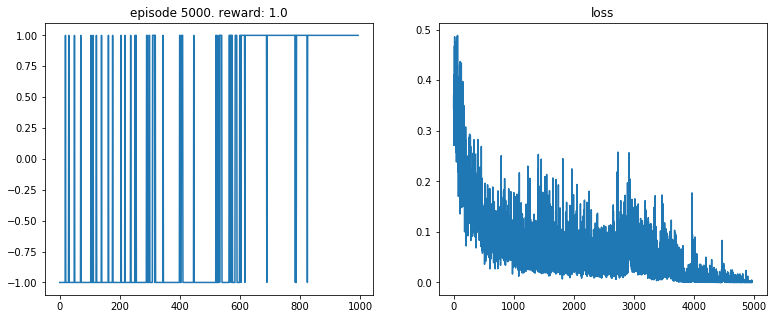

In [ ]:
import importlib
game_name = 'tictactoe'
game_module = importlib.import_module("games." + game_name)
env = game_module.Game()
env.reset()

n_state = 27

n_action = 9

episode = 5000

# model = DQN(n_state = n_state, n_action = n_action).to(device)

current_model = DQN(n_state = n_state, n_action = n_action).to(device)
target_model = DQN(n_state = n_state, n_action = n_action).to(device)
optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(1000)
update_target(current_model, target_model)

current_model, target_model, all_rewards, losses = train_DoubleDQN(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, episodes = episode, batch_size=32, gamma = 0.99)

In [ ]:
torch.save(current_model.state_dict(), 'weights_5000.pth')

### Show the result you playing a game against your learned agent.

In [ ]:
import importlib
game_name = 'tictactoe'
game_module = importlib.import_module("games." + game_name)
env = game_module.Game()
env.reset()

n_state = 27

n_action = 9

current_model = DQN(n_state = n_state, n_action = n_action).to(device)
current_model.load_state_dict(torch.load('weights_5000.pth'))


<All keys matched successfully>

In [ ]:
def play(model, player):
    done = False
    state = env.reset()
    state = state.reshape(-1)
    
    while(not done):
        if env.to_play() == player:
            available_action = env.legal_actions()
            print("available action:", available_action)
            action = env.human_to_action()
            # These will appear to select actions
            # Enter the row (1,2,3):
            # Enter the colume (1,2,3):
            next_state, reward, done = env.step(action)
            next_state = next_state.reshape(-1)
            print("Beau's turn")
            print(env.action_to_string(action))
        else:
            action = model.act(state, epsilon_final)
            next_state, reward, isq_done = env.step(action)
            next_state = next_state.reshape(-1)
            print("Model's turn")
            print(env.action_to_string(action))
        
        env.render()
        time.sleep(0.03)
        state = next_state

In [ ]:
# I play as O 
play(current_model,1)

available action: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Beau's turn
Play row 1, column 3
   |   | O 
---+---+---
   |   |   
---+---+---
   |   |   
Model's turn
Play row 3, column 1
   |   | O 
---+---+---
   |   |   
---+---+---
 X |   |   
available action: [0, 1, 3, 4, 5, 7, 8]
Beau's turn
Play row 1, column 1
 O |   | O 
---+---+---
   |   |   
---+---+---
 X |   |   
Model's turn
Play row 2, column 1
 O |   | O 
---+---+---
 X |   |   
---+---+---
 X |   |   
available action: [1, 4, 5, 7, 8]
Beau's turn
Play row 1, column 2
 O | O | O 
---+---+---
 X |   |   
---+---+---
 X |   |   


In [ ]:
# I play as X
play(current_model,-1)

Model's turn
Play row 2, column 2
   |   |   
---+---+---
   | O |   
---+---+---
   |   |   
available action: [0, 1, 2, 3, 5, 6, 7, 8]
Beau's turn
Play row 1, column 2
   | X |   
---+---+---
   | O |   
---+---+---
   |   |   
Model's turn
Play row 2, column 1
   | X |   
---+---+---
 O | O |   
---+---+---
   |   |   
available action: [0, 2, 5, 6, 7, 8]
Beau's turn
Play row 1, column 1
 X | X |   
---+---+---
 O | O |   
---+---+---
   |   |   
Model's turn
Play row 3, column 3
 X | X |   
---+---+---
 O | O |   
---+---+---
   |   | O 
available action: [2, 5, 6, 7]
Beau's turn
Play row 1, column 3
 X | X | X 
---+---+---
 O | O |   
---+---+---
   |   | O 
